In [1]:
!pip install catboost
!pip install category_encoders

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from category_encoders import CatBoostEncoder

from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

import matplotlib.pyplot as graph
import seaborn as sns


graph.style.use('fivethirtyeight')


def regression_report(model, x, y):
    print(f'Rsq = {r2_score(y, model.predict(x)):.4%}')
    print(f'MSE = {mean_squared_error(y, model.predict(x)):.4f}')
    print()

def causal_report(ψ, true_effect):
    abs_error = abs(ψ - true_effect)
    print(f'Mean Ψ = {ψ.mean():.4f}')
    print('Mean Error of Ψ')
    print(f'    {abs_error.mean():.4f}')
    print()
    return abs_error


def ω(g, t):
    return (t/g) + ((1-t)/(1-g))


# def ω(g, t):
#     return np.ones_like(g)


true_effect = 1.0
N = int(10e3)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def causal_dataset(n=10000, p=25, treatment_effect=0.5, groups=None, is_confounded=True, baseline=100):
    """
    Simulated causal dataset

    :param n:
    :param p:
    :param treatment_effect:
    :param groups: int or list of ints
    :param is_confounded: Whether selection bias should be functions
    :param baseline:
    :return: [df, x_cols, ]
    """
    # Setup quick fake data
    m = stats.norm().rvs(p)
    x = stats.norm().rvs((n, p))

    if is_confounded:
        # Confounded Trial (Selection Bias)
        true_propensity = expit((x[:, :5] @ m[:5]) + 2 * stats.norm().rvs(n))
        treatment_labels = true_propensity.round()
    else:
        # Randomized Controlled Trial
        treatment_labels = stats.bernoulli(p=0.5).rvs(n)

    y_oracle = x @ m + treatment_effect * treatment_labels + baseline
    y = y_oracle + stats.norm().rvs(n)

    # Test model
    x_cols = list(range(x.shape[1]))
    df_sim = pd.DataFrame(x, columns=x_cols)
    df_sim['y'] = y
    df_sim['treatment'] = treatment_labels

    if groups is not None:
        if isinstance(groups, list):
            for label, n_cat in zip(list('abcdefghijklmnopqrstuvwxyz'), groups):
                df_sim[label] = np.random.choice(list(range(n_cat)), size=n)
        elif isinstance(groups, int):
            df_sim['a'] = np.random.choice(list(range(groups)), size=n)
        else:
            raise ValueError('groups must be None, a list of ints or int')

    return df_sim, 'y', 'treatment', x_cols

In [4]:
df, _, _, x_cols = causal_dataset(n=N, treatment_effect=true_effect)

display(df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,y,treatment
0,0.000208,0.977570,0.876361,-0.090551,0.025503,0.528804,0.027053,1.987367,0.664258,0.680700,-0.284034,1.915374,-0.757952,-0.264212,-1.975945,0.133856,-0.440575,1.213818,-0.141567,-0.531861,1.199078,-0.431804,-0.866688,0.590372,-1.626178,104.084026,1.0
1,-0.347471,0.508242,1.486807,-0.422484,0.728795,1.937878,-0.195505,-0.303565,-1.591880,2.182033,0.395850,-1.580348,-1.584548,-0.400088,-0.118563,0.320088,-0.488115,2.139673,-0.271236,1.898419,-1.016896,1.087069,-0.001104,-0.699625,0.015961,98.792505,0.0
2,0.118143,-0.459323,-1.608429,0.218781,0.809773,0.355525,-0.177288,0.029273,-1.123488,1.910630,1.475551,-0.233513,-0.886838,0.275101,0.533527,1.370779,1.161518,0.301205,0.067991,-0.103004,-0.100747,0.537236,0.024088,-1.630069,-0.766982,97.531371,1.0
3,-0.508988,0.406647,-1.196317,-1.148918,0.301679,1.214176,0.276361,-0.276619,0.929199,-0.565612,0.642277,-0.970603,-1.406380,0.121600,0.407611,-1.357076,2.089409,1.347018,-1.521784,2.368646,0.667539,1.128301,-0.851948,-0.459729,1.494309,101.659419,1.0
4,2.621434,-1.352550,0.876852,0.716934,0.099097,0.733422,-0.912844,0.097112,-0.336001,0.710181,-1.079322,-0.685772,-1.890344,0.774052,0.388934,0.252038,1.741790,0.325316,0.948764,0.153073,0.330714,1.607198,1.089819,-0.217205,0.022012,104.172250,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.116552,-1.458677,0.394418,-0.211867,-0.791122,0.709761,-0.597026,-1.129047,-0.584663,-1.182514,1.820127,0.744887,-0.403713,1.104924,-0.026757,-1.590164,0.048047,1.971290,0.192292,0.058989,1.044485,-0.347406,0.814188,0.142175,-1.135331,97.243712,0.0
9996,0.859368,-0.139972,0.276840,1.622946,-0.311682,-0.238094,-1.842512,-1.222325,-0.596717,0.342837,0.146925,2.307062,0.323321,0.236092,0.658827,-0.658557,0.648457,-1.050280,-0.176353,-0.948535,-0.755443,1.235961,0.166930,-0.857952,0.372419,107.093759,1.0
9997,0.250893,1.578939,0.478961,-0.267153,-0.499919,0.976174,-0.582990,0.007184,-1.453816,0.782037,0.313201,0.483566,0.928695,-2.774500,0.245877,-1.627149,0.854330,1.423252,1.071477,-0.122783,1.355418,-2.114104,0.559416,1.005245,-1.128586,94.110420,1.0
9998,-1.359335,0.987536,1.552620,-0.527714,-1.252423,1.487581,0.570776,0.480136,0.488508,-0.788311,-1.002309,-0.905327,1.256796,-0.301201,-0.493345,0.533037,0.472123,-0.118815,1.325220,1.383318,-1.666090,0.850424,0.584376,-0.333658,-0.632610,100.305372,0.0


# Preprocessing

In [5]:
x, y, t = df[x_cols + ['treatment']], df['y'], df['treatment']

x0, x1 = x.copy(), x.copy()
x0['treatment'] = 0
x1['treatment'] = 1

print(x.shape, y.shape, t.shape)
print(x0.shape, x1.shape)

(10000, 26) (10000,) (10000,)
(10000, 26) (10000, 26)


In [6]:
x_train, x_test, y_train, y_test, t_train, t_test = train_test_split(x, y, t, test_size=0.1)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(9000, 26) (1000, 26) (9000,) (1000,)


# Compute Basic Propensity

In [7]:
%%time
g_model = LogisticRegressionCV().fit(x_train.drop(columns=['treatment']), t_train)  # Perfect Model
# g_model = RandomForestClassifier(1000, min_samples_leaf=5).fit(x_train.drop(columns=['treatment']), t_train)

g_train, g_test, g = [g_model.predict_proba(xi.drop(columns='treatment'))[:, 1] for xi in (x_train, x_test, x)]
print(g_train.shape, g_test.shape, g.shape)

(9000,) (1000,) (10000,)
CPU times: user 592 ms, sys: 348 ms, total: 940 ms
Wall time: 493 ms


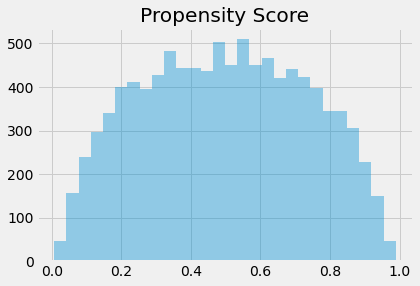

In [18]:
graph.title('Propensity Score')
sns.distplot(g, kde=False)
graph.show()

# CatBoost S-learner

In [8]:
catboost_kwargs = dict(
    iterations=int(10e3),
    learning_rate=0.3,
    early_stopping_rounds=25,
    use_best_model=True
)

catboost_model = CatBoostRegressor(**catboost_kwargs)
catboost_dr_model = CatBoostRegressor(**catboost_kwargs)

In [9]:
%%timeit
catboost_model.fit(
    x_train, y_train,
    sample_weight=ω(g_train, t_train),
    eval_set=(x_test, y_test),
    verbose=False
)

1 loop, best of 3: 2.93 s per loop


In [10]:
%%time
catboost_model.fit(
    x_train, y_train,
    eval_set=(x_test, y_test)
)

catboost_dr_model.fit(
    x_train, y_train,
    sample_weight=ω(g_train, t_train),
    eval_set=(x_test, y_test)
)

0:	learn: 5.0690929	test: 5.1099133	best: 5.1099133 (0)	total: 9.95ms	remaining: 1m 39s
1:	learn: 4.6155365	test: 4.6875701	best: 4.6875701 (1)	total: 20.2ms	remaining: 1m 40s
2:	learn: 4.2551537	test: 4.3166816	best: 4.3166816 (2)	total: 29.9ms	remaining: 1m 39s
3:	learn: 3.9790951	test: 4.0628661	best: 4.0628661 (3)	total: 39.7ms	remaining: 1m 39s
4:	learn: 3.7288943	test: 3.8216580	best: 3.8216580 (4)	total: 49.4ms	remaining: 1m 38s
5:	learn: 3.5360235	test: 3.6369320	best: 3.6369320 (5)	total: 59.1ms	remaining: 1m 38s
6:	learn: 3.3638711	test: 3.4641422	best: 3.4641422 (6)	total: 69.1ms	remaining: 1m 38s
7:	learn: 3.1901625	test: 3.2961604	best: 3.2961604 (7)	total: 78.8ms	remaining: 1m 38s
8:	learn: 3.0591838	test: 3.1683286	best: 3.1683286 (8)	total: 88.2ms	remaining: 1m 37s
9:	learn: 2.9351591	test: 3.0678285	best: 3.0678285 (9)	total: 97.5ms	remaining: 1m 37s
10:	learn: 2.8329633	test: 2.9734955	best: 2.9734955 (10)	total: 108ms	remaining: 1m 37s
11:	learn: 2.7361608	test: 2.86

# LightGBM S-Learner

In [11]:
lgbm_kwargs = dict(
    boosting_type='gbdt',
    n_estimators=int(10e3),
    learning_rate=0.1,
)

light_model = LGBMRegressor(**lgbm_kwargs)
light_dr_model = LGBMRegressor(**lgbm_kwargs)

In [12]:
%%timeit
light_model.fit(
    x_train, y_train,
    sample_weight=ω(g_train, t_train),
    eval_set=(x_test, y_test),
    early_stopping_rounds=25,
    verbose=False
)

1 loop, best of 3: 3.83 s per loop


In [13]:
%%time
light_model.fit(
    x_train, y_train,
    eval_set=(x_test, y_test),
    early_stopping_rounds=25,
)

light_dr_model.fit(
    x_train, y_train,
    sample_weight=ω(g_train, t_train),
    eval_set=(x_test, y_test),
    early_stopping_rounds=25,
)

[1]	valid_0's l2: 30.6655
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's l2: 28.3416
[3]	valid_0's l2: 26.2987
[4]	valid_0's l2: 24.4696
[5]	valid_0's l2: 22.9448
[6]	valid_0's l2: 21.6899
[7]	valid_0's l2: 20.4788
[8]	valid_0's l2: 19.4964
[9]	valid_0's l2: 18.6506
[10]	valid_0's l2: 17.8094
[11]	valid_0's l2: 17.1209
[12]	valid_0's l2: 16.3886
[13]	valid_0's l2: 15.7883
[14]	valid_0's l2: 15.2086
[15]	valid_0's l2: 14.7063
[16]	valid_0's l2: 14.222
[17]	valid_0's l2: 13.8232
[18]	valid_0's l2: 13.4043
[19]	valid_0's l2: 13.0366
[20]	valid_0's l2: 12.6033
[21]	valid_0's l2: 12.2404
[22]	valid_0's l2: 11.8794
[23]	valid_0's l2: 11.4736
[24]	valid_0's l2: 11.1894
[25]	valid_0's l2: 10.9351
[26]	valid_0's l2: 10.6592
[27]	valid_0's l2: 10.3912
[28]	valid_0's l2: 10.0917
[29]	valid_0's l2: 9.84054
[30]	valid_0's l2: 9.57643
[31]	valid_0's l2: 9.33464
[32]	valid_0's l2: 9.10132
[33]	valid_0's l2: 8.87603
[34]	valid_0's l2: 8.64234
[35]	valid_0's l2: 8.41263
[36

# Comparing Results

In [14]:
print('CatBoost')
regression_report(catboost_model, x_train, y_train)
regression_report(catboost_model, x_test, y_test)

print('LightGBM')
regression_report(light_model, x_train, y_train)
regression_report(light_model, x_test, y_test)

CatBoost
Rsq = 97.8398%
MSE = 0.7105

Rsq = 95.3538%
MSE = 1.5520

LightGBM
Rsq = 99.3146%
MSE = 0.2254

Rsq = 92.7046%
MSE = 2.4369



CatBoost
Mean Ψ = 1.0372
Mean Error of Ψ
    0.1672

Catboost DR
Mean Ψ = 1.0016
Mean Error of Ψ
    0.1674

LightGBM
Mean Ψ = 0.9886
Mean Error of Ψ
    0.3960

LightGBM DR
Mean Ψ = 0.9711
Mean Error of Ψ
    0.3929



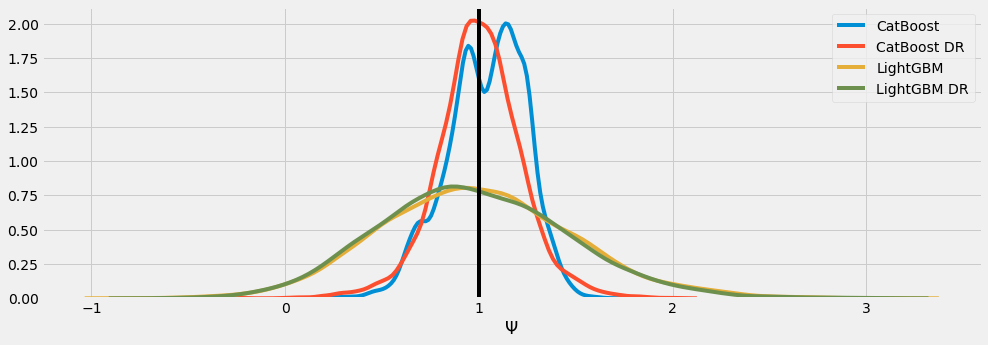

In [15]:
ψ_catboost = catboost_model.predict(x1) - catboost_model.predict(x0)
ψ_catboost_dr = catboost_dr_model.predict(x1) - catboost_dr_model.predict(x0)
ψ_lightgbm = light_model.predict(x1) - light_model.predict(x0)
ψ_lightgbm_dr = light_dr_model.predict(x1) - light_dr_model.predict(x0)

print('CatBoost')
causal_report(ψ_catboost, true_effect)

print('Catboost DR')
causal_report(ψ_catboost_dr, true_effect)

print('LightGBM')
causal_report(ψ_lightgbm, true_effect)

print('LightGBM DR')
causal_report(ψ_lightgbm_dr, true_effect)


graph.figure(figsize=(15, 5))
sns.distplot(ψ_catboost, hist=False, label='CatBoost')
sns.distplot(ψ_catboost_dr, hist=False, label='CatBoost DR')
sns.distplot(ψ_lightgbm, hist=False, label='LightGBM')
sns.distplot(ψ_lightgbm_dr, hist=False, label='LightGBM DR')
graph.axvline(true_effect, color='black')
graph.xlabel('Ψ')
graph.legend()
graph.show()

In [16]:
cate_model = sm.WLS(
    ψ_catboost_dr, 
    sm.add_constant(x.drop(columns='treatment')),
    weights=g
).fit()

display(cate_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.079
Model:                            WLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     34.04
Date:                Mon, 22 Jun 2020   Prob (F-statistic):          2.47e-156
Time:                        04:30:11   Log-Likelihood:                 548.70
No. Observations:               10000   AIC:                            -1045.
Df Residuals:                    9974   BIC:                            -857.9
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9919      0.002    410.867      0.000       0.987       0.997
0              0.0086      0.002      3.682      0.000       0.004       0.013
1              0.0079      0.002      3.573      0.000       0.004       0.012
2              0.0053      0.002      2.513      0.012       0.001       0.010
3             -0.0107      0.002     -5.030      0.000      -0.015      -0.007
4              0.0006      0.002      0.257      0.797      -0.004       0.005
5             -0.0034      0.002     -1.611      0.107      -0.008       0.001
6             -0.0124      0.002     -5.729      0.000      -0.017      -0.008
7              0.0118      0.002      5.520      0.000       0.008       0.016
8              0.0079      0.002      3.699      0.000       0.004       0.012
9             -0.0185      0.002     -8.748      0.000      -0.023      -0.014
10            -0.0055      0.002     -2.588      0.010      -0.010      -0.001
11             0.0169      0.002      7.971      0.000       0.013       0.021
12            -0.0035      0.002     -1.646      0.100      -0.008       0.001
13             0.0124      0.002      5.851      0.000       0.008       0.017
14            -0.0074      0.002     -3.557      0.000      -0.011      -0.003
15             0.0247      0.002     11.759      0.000       0.021       0.029
16             0.0004      0.002      0.206      0.837      -0.004       0.005
17            -0.0026      0.002     -1.252      0.211      -0.007       0.001
18             0.0039      0.002      1.848      0.065      -0.000       0.008
19            -0.0102      0.002     -4.861      0.000      -0.014      -0.006
20            -0.0027      0.002     -1.268      0.205      -0.007       0.001
21            -0.0389      0.002    -18.279      0.000      -0.043      -0.035
22             0.0054      0.002      2.542      0.011       0.001       0.010
23            -0.0012      0.002     -0.597      0.550      -0.005       0.003
24            -0.0043      0.002     -2.054      0.040      -0.008      -0.000
==============================================================================
Omnibus:                     1082.952   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7218.348
Skew:                          -0.296   Prob(JB):                         0.00
Kurtosis:                       7.120   Cond. No.                         1.69
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

CatBoost
Mean Ψ = 1.0372
Mean Error of Ψ
    0.1672

Catboost DR
Mean Ψ = 1.0016
Mean Error of Ψ
    0.1674

CatBoost DR with WLS-Ψ
Mean Ψ = 0.9932
Mean Error of Ψ
    0.0499

LightGBM
Mean Ψ = 0.9886
Mean Error of Ψ
    0.3960

LightGBM DR
Mean Ψ = 0.9711
Mean Error of Ψ
    0.3929



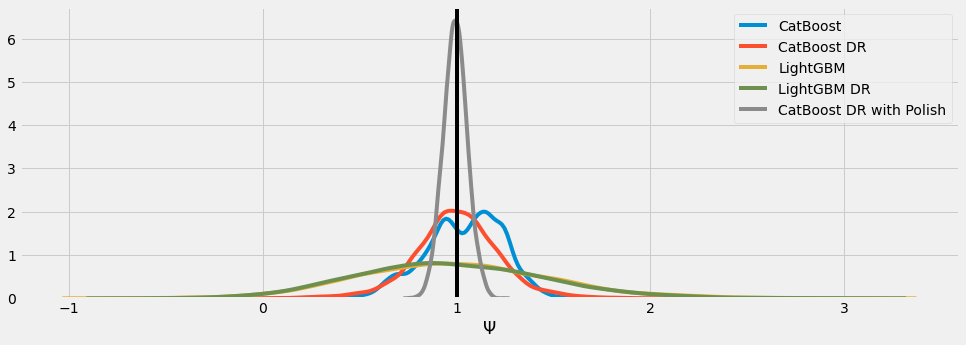

In [17]:
print('CatBoost')
causal_report(ψ_catboost, true_effect)

print('Catboost DR')
causal_report(ψ_catboost_dr, true_effect)

print('CatBoost DR with WLS-Ψ')
causal_report(cate_model.fittedvalues, true_effect)

print('LightGBM')
causal_report(ψ_lightgbm, true_effect)

print('LightGBM DR')
causal_report(ψ_lightgbm_dr, true_effect)


graph.figure(figsize=(15, 5))
sns.distplot(ψ_catboost, hist=False, label='CatBoost')
sns.distplot(ψ_catboost_dr, hist=False, label='CatBoost DR')
sns.distplot(ψ_lightgbm, hist=False, label='LightGBM')
sns.distplot(ψ_lightgbm_dr, hist=False, label='LightGBM DR')
sns.distplot(cate_model.fittedvalues, hist=False, label='CatBoost DR with Polish')
graph.axvline(true_effect, color='black')
graph.xlabel('Ψ')
graph.legend()
graph.show()